In [ ]:
collaboratory = True

if collaboratory:
    from google.colab import drive
    drive.mount('/content/drive')
else: 
    print('Running on local systems, if running on collaboratory please change above')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Obj_detection/stemness/Data/Two_Types.zip" -d "/content"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
# from torchvision import *
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
batch_size = 256
learning_rate = 0.002
font = {'family' : 'Arial',
        'size'   : 20}

plt.rc('font', **font)

train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ColorJitter(brightness = 0.25, contrast=0.25),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),

])

In [ ]:
from torchvision import datasets
import matplotlib.pyplot as plt
import time
import copy
import os
import sklearn
import sklearn.model_selection


# transforms = transforms.Compose([transforms.Resize((24,24)),  transforms.RandomRotation([-8, +8]), transforms.ToTensor()])
val_transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor()
# , transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ,transforms.Normalize([0.5], [0.5])
])

# HSCdataset = datasets.ImageFolder('./NewSlamZip/', transform=val_transform)
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.6) , len(dataset)- int(len(dataset) * 0.6)])

# train_dataset = datasets.ImageFolder('./NewSlamZip/', transform=train_transform)
# val_dataset =datasets.ImageFolder('./NewSlamZip/', transform=val_transform)

# train_dataset = datasets.ImageFolder('./MPP-tifs/', transform=train_transform)
# val_dataset =datasets.ImageFolder('./MPP-tifs/', transform=val_transform)

train_dataset = datasets.ImageFolder('./Two_Types/', transform=train_transform)
val_dataset =datasets.ImageFolder('./Two_Types/', transform=val_transform)
# test_dataset = datasets.ImageFolder('./0119', transform=val_transform)

# the indices can be obtained as follow:

num_train = len(train_dataset)
indices = list(range(num_train))
val_size = 0.8
split_idx = int(np.floor(val_size * num_train))

train_idx, valid_idx = indices[:split_idx], indices[split_idx:]
assert len(train_idx) != 0 and len(valid_idx) != 0

# generate indices: instead of the actual data we pass in integers instead
# train_indices, test_indices, _, _ = train_test_split(
#     range(len(data)),
#     data.targets,
#     stratify=data.targets,
#     test_size=TEST_SIZE,
#     random_state=SEED
# )
TEST_SIZE = 0.25
train_indices, val_indices = sklearn.model_selection.train_test_split(
    indices,
    stratify = train_dataset.targets, # for stratify sampling the data due to the unblanced dataset
    random_state = 42,
    test_size=TEST_SIZE
    )

train_dataloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# class_sample_count = np.array([4100, 1800, 880])
class_sample_count = np.array([np.where(np.array(train_dataset.targets) == 0)[0].shape, 
                            np.where(np.array(train_dataset.targets) == 1)[0].shape
                            # ,np.where(np.array(train_dataset.targets) == 2)[0].shape]
                                ])
class_sample_count = class_sample_count.ravel() # this has to be (3, ) otherwise trigger problems for dataloader

weight = 1. / class_sample_count

targetlst = list(train_dataset.targets)
targets = np.array(targetlst)

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices) # change

samples_weight = np.array([weight[t] for t in targets[train_indices]])

sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True) 

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size,sampler = sampler, pin_memory=True)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp, cmap=plt.get_cmap('gray'))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)


# imshow(out, title=[train_dataset.classes[x] for x in labels])

images-size: torch.Size([256, 3, 128, 128])
out-size: torch.Size([3, 4162, 1042])


In [ ]:
import torchvision.models as models
net = models.resnet50(pretrained=True)
net = net.cuda() if torch.cuda.is_available() else net

# # Freeze the conv layers
# for param in net.parameters():
#     param.requires_grad = False


def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 3)


net.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(512, 2))


net.fc = net.fc.cuda() if torch.cuda.is_available() else net.fc

criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(net.parameters(), lr = learning_rate, weight_decay=0)

ignored_params = list(map(id, net.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     net.parameters())
learning_rate = 4e-3
optimizer = torch.optim.Adam([
            {'params': base_params},
            {'params': net.fc.parameters(), 'lr': learning_rate}
        ], lr = learning_rate * 0.01)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
n_epochs = 35
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)

for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), './drive/My Drive/HSC/TBCells.pt')
            print('Improvement-Detected, save-model')
    net.train()


Epoch 1

Epoch [1/35], Step [0/59], Loss: 0.7123
Epoch [1/35], Step [10/59], Loss: 0.6001
Epoch [1/35], Step [20/59], Loss: 0.4235
Epoch [1/35], Step [30/59], Loss: 0.3904
Epoch [1/35], Step [40/59], Loss: 0.3756
Epoch [1/35], Step [50/59], Loss: 0.3750

train-loss: 0.6340, train-acc: 76.9000
validation loss: 0.4363, validation acc: 79.2000

Improvement-Detected, save-model
Epoch 2

Epoch [2/35], Step [0/59], Loss: 0.3591
Epoch [2/35], Step [10/59], Loss: 0.2898
Epoch [2/35], Step [20/59], Loss: 0.2671
Epoch [2/35], Step [30/59], Loss: 0.2276
Epoch [2/35], Step [40/59], Loss: 0.2878
Epoch [2/35], Step [50/59], Loss: 0.2546

train-loss: 0.4658, train-acc: 87.1467
validation loss: 0.3661, validation acc: 86.8000

Improvement-Detected, save-model
Epoch 3

Epoch [3/35], Step [0/59], Loss: 0.2652
Epoch [3/35], Step [10/59], Loss: 0.3113
Epoch [3/35], Step [20/59], Loss: 0.3184
Epoch [3/35], Step [30/59], Loss: 0.2411
Epoch [3/35], Step [40/59], Loss: 0.2459
Epoch [3/35], Step [50/59], Loss:

KeyboardInterrupt: ignored

[89.28 93.68]
0.9148
              precision    recall  f1-score   support

     B_Cells       0.93      0.89      0.91      2500
     T_Cells       0.90      0.94      0.92      2500

    accuracy                           0.91      5000
   macro avg       0.92      0.91      0.91      5000
weighted avg       0.92      0.91      0.91      5000



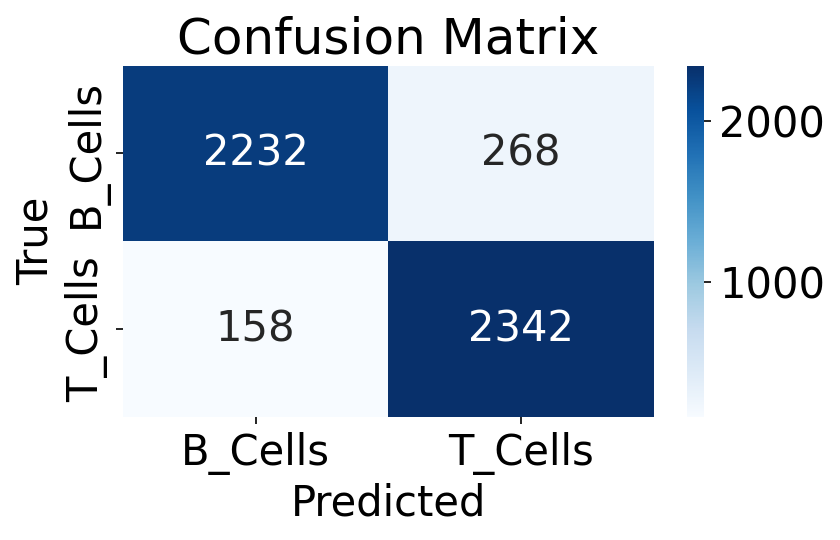

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long)
lbllist=torch.zeros(0,dtype=torch.long)

trained_model_PATH = './drive/My Drive/HSC/TBCells2Types.pt'
net.load_state_dict(torch.load(trained_model_PATH))

net.eval()

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])
# Confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# print(conf_mat)
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
# print(confusion_matrix)

cf_matrix = confusion_matrix(lbllist.numpy(), predlist.numpy())
categories = ["B_Cells", "T_Cells"]
import seaborn as sns
fig, ax = plt.subplots(dpi = 150)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["B_Cells", "T_Cells"]); ax.yaxis.set_ticklabels(["B_Cells", "T_Cells"]);
acc = accuracy_score(lbllist.numpy(),predlist.numpy())
plt.xlabel('Predicted')
plt.ylabel('True')
print(acc)


from sklearn.metrics import classification_report
target_names = ["B_Cells", "T_Cells"]
print(classification_report(lbllist.numpy(), predlist.numpy(), target_names=target_names))
fig.tight_layout()

plt.savefig("CM.svg", dpi=150)
plt.savefig("CM.png", dpi=150)

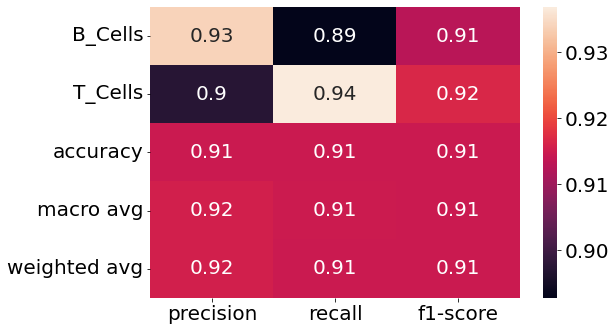

In [ ]:
import pandas as pd
plt.rcParams.update({'font.size': 20})

report1 = classification_report(lbllist.numpy(), predlist.numpy(), target_names=target_names, output_dict=True)
df = pd.DataFrame(report1)
df.drop(columns=['accuracy'])
fig, ax = plt.subplots(1, 1, figsize = (9, 5))
# df.iloc[:3, :3].plot(kind='bar',  colormap='Paired',  rot=0, ax=ax)


sns.heatmap(df.iloc[:-1, :].T, annot=True)
fig.tight_layout()
plt.savefig("Training_details.svg", dpi=150)
plt.savefig("Training_details.png", dpi=150)